## opcode, register 빈도수로 학습

In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import glob
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
train_benign_df = pd.read_csv("./csv_files/train_benign_asmfile.txt")
train_benign_df.drop(train_benign_df.columns[-1], axis=1, inplace=True)
train_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_benign_df['label'] = 0

train_malware_df = pd.read_csv("./csv_files/train_malware_asmfile.txt")
train_malware_df.drop(train_malware_df.columns[-1], axis=1, inplace=True)
train_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_malware_df['label'] = 1

test_benign_df = pd.read_csv("./csv_files/test_benign_asmfile.txt")
test_benign_df.drop(test_benign_df.columns[-1], axis=1, inplace=True)
test_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_benign_df['label'] = 0

test_malware_df = pd.read_csv("./csv_files/test_malware_asmfile.txt")
test_malware_df.drop(test_malware_df.columns[-1], axis=1, inplace=True)
test_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_malware_df['label'] = 1

valid_benign = pd.read_csv("./csv_files/valid_benign_asmfile.txt")
valid_benign.drop(valid_benign.columns[-1], axis=1, inplace=True)
valid_benign.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_benign['label'] = 0

valid_malware = pd.read_csv("./csv_files/valid_malware_asmfile.txt")
valid_malware.drop(valid_malware.columns[-1], axis=1, inplace=True)
valid_malware.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_malware['label'] = 1


In [3]:
import sklearn
df_list = [train_benign_df, train_malware_df, test_benign_df, test_malware_df, valid_benign, valid_malware]
full_df = pd.concat(df_list, ignore_index=True, axis=0)
full_shuffled_df = sklearn.utils.shuffle(full_df)
full_shuffled_df

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
28,0e3195408a12d003c37b1f30af1ba3ed,276,9071,0,3158,1218,837,881,2,274,...,0,0,1,0,0,0,0,0,0,0
1362,1b921a53336d842dee6ff7c6adbb236d,871,1539,17,595,19,6,274,1,13,...,0,0,0,0,0,0,83,0,288,1
1391,1e3329c604cc1fa335f84b58c965b9b7,998,10986,4,8391,399,161,276,0,567,...,0,0,0,0,0,0,53,0,0,1
428,00d05b142721796ed50ca1fdd6674aac,1670,22237,0,16196,4627,1594,2353,1,1866,...,0,0,0,0,0,0,1,0,0,0
627,1bde3d5ab8aac7711efafd3bcd400c41,239,1485,0,3139,344,299,159,0,93,...,0,0,0,0,0,0,24,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,05ff1439f594f69775452176c6a5c5d9,15013,143574,0,73582,24223,9992,11277,533,5515,...,0,0,0,4,16,0,60,543,125,1
1350,04cd16133ce07c96a5b5e158cea051e0,511,5166,0,7144,152,34,109,0,89,...,0,0,0,0,0,0,2,0,0,1
838,18dc5af7f47f5e38dfa0623976d0bd75,1624,10289,0,5461,1473,806,599,0,595,...,0,0,0,36,0,0,7,143,56,0
1458,1c791322f57dacff8a602782c47b6e6f,33,672,0,145,81,164,79,1,107,...,0,0,0,0,0,0,0,4,5,1


### 정규화

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
NORMALIZE_VALID_COLUMNS = [ 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword']

full_shuffled_df[NORMALIZE_VALID_COLUMNS] = scaler.fit_transform(full_shuffled_df[NORMALIZE_VALID_COLUMNS])
full_shuffled_df[NORMALIZE_VALID_COLUMNS].astype('float')

,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,...,eax,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword
28,0.002647,0.005619,0.000000,0.005220,0.005313,0.005361,0.010283,0.000086,0.002462,0.000267,...,0.0,0.0,0.0,0.1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1362,0.008354,0.000946,0.012169,0.000983,0.000083,0.000038,0.003198,0.000043,0.000117,0.000941,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.245562,0.000000,0.009758
1391,0.009572,0.006807,0.002863,0.013869,0.001741,0.001031,0.003222,0.000000,0.005095,0.000351,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.156805,0.000000,0.000000
428,0.016017,0.013788,0.000000,0.026769,0.020184,0.010209,0.027465,0.000043,0.016768,0.014934,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002959,0.000000,0.000000
627,0.002292,0.000912,0.000000,0.005188,0.001501,0.001915,0.001856,0.000000,0.000836,0.001545,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.071006,0.000000,0.000271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,0.143990,0.089076,0.000000,0.121616,0.105668,0.063997,0.131627,0.023005,0.049559,0.037581,...,0.0,0.0,0.0,0.0,0.027778,0.163265,0.0,0.177515,0.026160,0.004235
1350,0.004901,0.003196,0.000000,0.011808,0.000663,0.000218,0.001272,0.000000,0.000800,0.000520,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.005917,0.000000,0.000000
838,0.015576,0.006375,0.000000,0.009026,0.006426,0.005162,0.006992,0.000000,0.005347,0.004903,...,0.0,0.0,0.0,0.0,0.250000,0.000000,0.0,0.020710,0.006889,0.001897
1458,0.000317,0.000408,0.000000,0.000240,0.000353,0.001050,0.000922,0.000043,0.000962,0.000112,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000193,0.000169


### train_test_split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_shuffled_df[NORMALIZE_VALID_COLUMNS],full_shuffled_df['label'], stratify=full_shuffled_df['label'], test_size=0.2, random_state=42)

###  label값 개수를 동일하게 하기 위한 교차검증 사용 (stratifiedKFold)

#### DecisionTree Classifier

### 주성분검출(PCA)

In [10]:
from sklearn.decomposition import PCA

skpca = PCA(n_components=5)
X_pca = skpca.fit_transform(X_train)
print('Variance sum : ', skpca.explained_variance_ratio_.cumsum()[-1])

Variance sum :  0.748333571697626


In [11]:
features = full_shuffled_df[NORMALIZE_VALID_COLUMNS]
label = full_shuffled_df['label']

In [12]:
# from sklearn.model_selection import StratifiedKFold

# # decision tree 모델 생성
# dt_clf = DecisionTreeClassifier(random_state= 10)
# skf = StratifiedKFold(n_splits=2)
# n_iter = 0

# for train_index, test_index in skf.split(features, label):
#   n_iter += 1
#   label_train = label.iloc[train_index]
#   label_test = label.iloc[test_index]
#   X_train, X_test = features.iloc[list(train_index)], features.iloc[list(test_index)]
#   y_train, y_test = label.iloc[list(train_index)], label.iloc[list(test_index)]
#   dt_clf.fit(X_train, y_train)
#   print('------------ 교차 검증 ------------ : {}'.format(n_iter))  
#   print('교차 검증 정확도 : {}'.format(accuracy_score(y_test, dt_clf.predict(X_test))))
#   print('학습 레이블(label_train) 데이터 분포 : \n', label_train.value_counts())
#   print('검증 레이블(label_train) 데이터 분포 : \n', label_test.value_counts())
#   print('\n')

### RandomForestClassifier

In [13]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report, confusion_matrix

model = RFC(n_estimators=100, random_state=0, 
                          oob_score = True,
                          max_depth = 16, 
                          max_features = 'sqrt')

model.fit(X_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
X_test_pca = skpca.transform(X_test_new)

y_pred = model.predict(X_test_pca)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.05      0.09       280
           1       0.51      1.00      0.67       279

    accuracy                           0.52       559
   macro avg       0.72      0.52      0.38       559
weighted avg       0.72      0.52      0.38       559



In [14]:
model = RFC(n_estimators=100, random_state=0, 
                          oob_score = True,
                          max_depth = 16, 
                          max_features = 'sqrt')

features = full_shuffled_df[NORMALIZE_VALID_COLUMNS]
label = full_shuffled_df['label']
skf = StratifiedKFold(n_splits=2)
n_iter = 0

X_test_scaled = scaler.transform(X_test)
X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
X_test_pca = skpca.transform(X_test_new)

for train_index, test_index in skf.split(features, label):
  n_iter += 1
  label_train = label.iloc[train_index]
  label_test = label.iloc[test_index]
  X_pca, X_test_pca = features.iloc[list(train_index)], features.iloc[list(test_index)]
  y_train, y_test = label.iloc[list(train_index)], label.iloc[list(test_index)]
  model.fit(X_pca, y_train)
  print('------------ 교차 검증 ------------ : {}'.format(n_iter))  
  print('교차 검증 정확도 : {}'.format(accuracy_score(y_test, model.predict(X_test_pca))))
  print('학습 레이블(label_train) 데이터 분포 : \n', label_train.value_counts())
  print('검증 레이블(label_train) 데이터 분포 : \n', label_test.value_counts())
  print('\n')


NameError: name 'StratifiedKFold' is not defined

<AxesSubplot:>

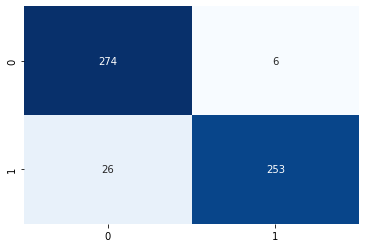

In [24]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### Support Vector Machine

In [25]:
from sklearn.svm import SVC

In [26]:
model = SVC()

In [27]:
model.fit(X_pca,y_train)

SVC()

In [28]:
predictions = model.predict(X_test_pca)

In [29]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.39      0.53       280
           1       0.60      0.92      0.73       279

    accuracy                           0.65       559
   macro avg       0.71      0.66      0.63       559
weighted avg       0.71      0.65      0.63       559



<AxesSubplot:>

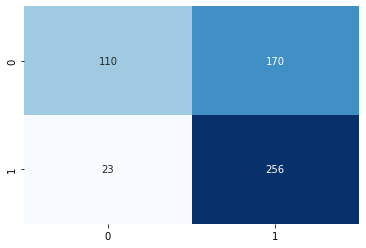

In [30]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### 하이퍼 파라미터 search (GridSearchCV)

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
params = { 'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80],
           'max_depth' : [14, 16, 18, 20, 22],
           'min_samples_leaf' : [2, 3, 4],
           'min_samples_split' : [1, 2, 3, 4]
            }

In [33]:
hipher_rf_clf = RandomForestClassifier(random_state=0, n_jobs = -1, max_features = 'sqrt')
grid_cv = GridSearchCV(hipher_rf_clf, params, cv = 5, n_jobs=-1)
grid_cv.fit(X_pca, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도 : {:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:  {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 40}
최고 예측 정확도 : 0.9105


In [36]:
rf_best = RandomForestClassifier(n_estimators=40,
                                 max_depth=16,
                                 min_samples_leaf=2,
                                 min_samples_split=3,
                                 random_state=2,
                                 n_jobs=-1)
rf_best.fit(X_pca, y_train)

pred = rf_best.predict(X_test_pca)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       280
           1       0.95      0.92      0.93       279

    accuracy                           0.94       559
   macro avg       0.94      0.94      0.94       559
weighted avg       0.94      0.94      0.94       559



random_state를 바꿀 때 마다 성능이 달라짐  
-> bag of words로 하면 데이터의 양이 적어 일어나는 것으로 판단 근데 업스케일링은 못함 왜냐? benign과 malware의 label 개수가 동등하기 때문

PCA 적용시 성능 오히려 낮아짐 -> 안하는게 좋을 것 같음